In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import numpy as np
import pymc as pm


project_dir = Path.cwd().parent
train_df = pd.read_csv(project_dir / "data" / "model" / "training_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)


# train_df['y'] = train_df.sum(axis=1)
# train_df.index = pd.to_datetime(train_df.index)
# train_df.index.freq = train_df.index.inferred_freq


In [10]:
delays_df = pd.read_csv(project_dir / "data" / "transformed" / "DENG_delays.csv")
delays_df['Collection date'] = pd.to_datetime(delays_df['Collection date'])
delays_df.index = delays_df['Collection date']
delays_df = delays_df.drop(columns=['Collection date'])
delays_df['y'] = delays_df.sum(axis=1)
delays_df


,delay_0,delay_1,delay_2,delay_3,delay_4,delay_5,delay_6,delay_7,delay_8,delay_9,...,delay_31,delay_32,delay_33,delay_34,delay_35,delay_36,delay_37,delay_38,delay_39,y
Collection date,,,,,,,,,,,,,,,,,,,,,
2012-01-01,129.0,268.0,318.0,341.0,278.0,207.0,47.0,33.0,126.0,81.0,...,6.0,10.0,4.0,1.0,1.0,5.0,5.0,2.0,2.0,2111.0
2012-01-02,243.0,406.0,370.0,394.0,270.0,60.0,22.0,238.0,114.0,64.0,...,6.0,9.0,1.0,1.0,7.0,6.0,4.0,2.0,3.0,2431.0
2012-01-03,295.0,446.0,446.0,333.0,82.0,49.0,220.0,135.0,90.0,56.0,...,4.0,1.0,1.0,4.0,7.0,1.0,0.0,2.0,0.0,2321.0
2012-01-04,282.0,520.0,375.0,144.0,68.0,231.0,158.0,120.0,77.0,32.0,...,0.0,0.0,3.0,3.0,0.0,0.0,1.0,1.0,1.0,2166.0
2012-01-05,302.0,439.0,147.0,102.0,311.0,186.0,144.0,109.0,93.0,9.0,...,1.0,13.0,2.0,5.0,2.0,5.0,0.0,1.0,2.0,2067.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,465.0,979.0,757.0,402.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2603.0
2023-12-28,574.0,835.0,409.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1818.0
2023-12-29,503.0,606.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1109.0


Timestamp('2015-01-25 00:00:00')

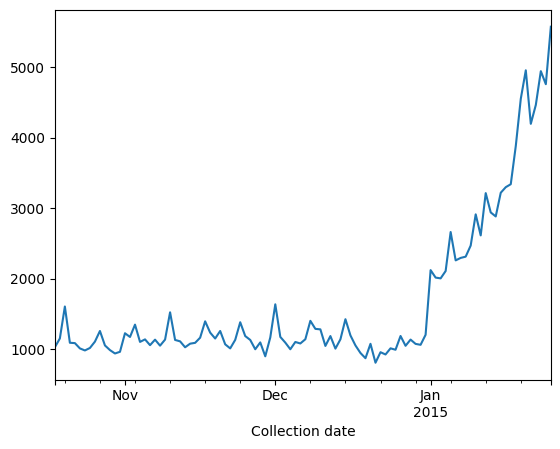

In [53]:

D = 40

N = len(delays_df) - D + 1
reporting_matrices = np.empty((N, D, D))

def mask_matrix(matrix):
        masked_matrix = matrix.copy()
        nrow, ncol = masked_matrix.shape

        for i in range(nrow):
            for j in range(ncol):
                if i + j > D - 1:
                     masked_matrix[i, j] = 0
        return  masked_matrix

start_index = 1021
length = 100
data = delays_df[start_index:start_index+length]
y = data['y']
y.plot()
Z = data.drop('y', axis=1)
Z[-D:] = mask_matrix(np.array(Z[-D:]))

y_obs = np.array(Z).sum(axis=1)
y.index[-1]

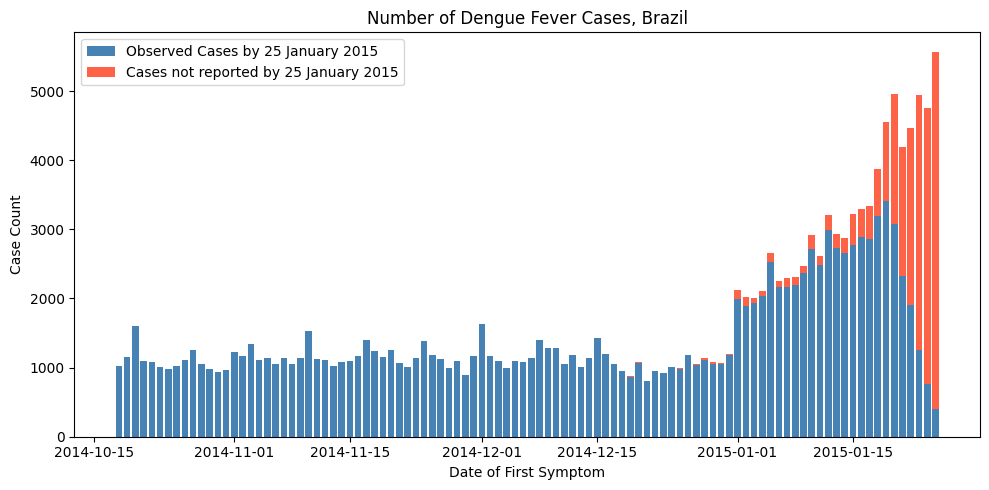

In [55]:
# Compute the under-reported portion
y_gap = y - y_obs

# X-axis positions
x = np.arange(len(y))

# Plot stacked bars
plt.figure(figsize=(10, 5))
plt.bar(y.index, y_obs, color="steelblue", label=f"Observed Cases by {y.index[-1].strftime("%d %B %Y")}")
plt.bar(y.index, y_gap, bottom=y_obs, color="tomato", label=f"Cases not reported by {y.index[-1].strftime("%d %B %Y")}")

plt.title("Number of Dengue Fever Cases, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.legend()
plt.tight_layout()
plt.show()